$ \textbf{Aluna:}$ Alessandra da Silva Dias Malizia   
$ \textbf{Data:}$ 08/12/2024

In [1]:
import io
import sys
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.stattools import kpss
from pmdarima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import acf, pacf, breakvar_heteroskedasticity_test
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm
import scipy.stats as stats
from xgboost import XGBRegressor, plot_importance
import yfinance as yf
from arch import arch_model

## Download da Série

In [2]:
data = yf.Ticker('AAPL')
series = data.history(auto_adjust=True, period='10y')[['Close']]
idx_train_split = int(0.7*series.shape[0])

pd.DataFrame(index=['Metadados'], data={
    'Fonte':'Yahoo Finance', 
    'Ação': data.info['shortName'] + ' ({})'.format(data.info['symbol']),
    'Unidade': data.info['currency'],
    'Período da série': '{} a {}'.format(series.index[0].strftime('%d/%m/%Y'), series.index[-1].strftime('%d/%m/%Y')),
    'Período de treino': '{} a {}'.format(series.index[0].strftime('%d/%m/%Y'), series.index[idx_train_split-1].strftime('%d/%m/%Y')),
    'Período de teste': '{} a {}'.format(series.index[idx_train_split].strftime('%d/%m/%Y'), series.index[-1].strftime('%d/%m/%Y')),
}).T

,Metadados
Fonte,Yahoo Finance
Ação,Apple Inc. (AAPL)
Unidade,USD
Período da série,08/12/2014 a 06/12/2024
Período de treino,08/12/2014 a 03/12/2021
Período de teste,06/12/2021 a 06/12/2024


# Tarefa 1: Fatos estilizados

## i) Série de retornos

Como esperado, a série de retornos artiméticos possui valores muito próximos da série de retornos logarítmicos. Isso acontece devido à aproximação $ \ln(1 + R_t) \approx R_t$, quando $ R_t << 1$. Quando a variação percentual ($ R_t$) é muito menor que 1, a aproximação implica que $ R_t = \ln(y_t) - \ln(y_{t-1}) = r_t$, ou seja, que os retornos aritmético e logarítmico são iguais. 

A aproximação não é válida quando o retorno aritmético é alto. Isso pode ser observado no gráfico principalmente no período da pandemia de COVID, em 2020, quando houve muita oscilação na bolsa, e a diferença entre as duas séries de retorno foi diferente de zero.

In [3]:
# cálculo do retorno aritmético e logarítmico
ret = pd.DataFrame(columns=['pct','log'])
ret['pct'] = series.pct_change().dropna()
ret['log'] = np.log(series).diff().dropna()

# diferença entre os cálculos
ret.diff(axis=1).iloc[:,-1].mul(100).abs().where(lambda x: x>0.5).dropna()

Date
2019-01-03 00:00:00-05:00    0.531701
2020-03-12 00:00:00-04:00    0.522311
2020-03-13 00:00:00-04:00    0.665077
2020-03-16 00:00:00-04:00    0.906107
2020-07-31 00:00:00-04:00    0.512514
Name: log, dtype: float64

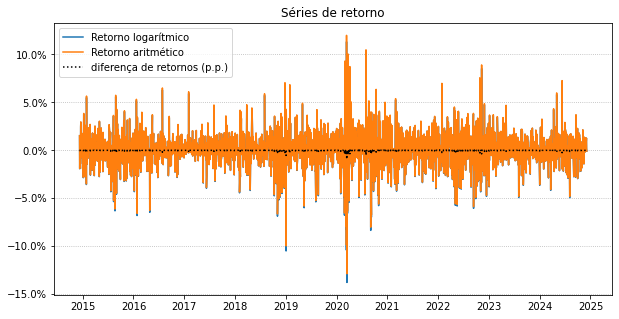

In [4]:
# gráfico de retornos
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ret['log'].mul(100), label='Retorno logarítmico')
ax.plot(ret['pct'].mul(100), label='Retorno aritmético')
ax.plot(ret.diff(axis=1).iloc[:,-1].mul(100), color='black', linestyle=':', 
        label='diferença de retornos (p.p.)')
ax.yaxis.set_major_formatter( mtick.PercentFormatter())
ax.grid(axis='y', linestyle=':')
ax.legend()
ax.set_title('Séries de retorno')
plt.show()

## ii) Análise do período de treinamento

Como esperado, os gráficos do retorno logarítmico e aritmético no período de treino apresentam clusters de volatilidade, com alguns exemplos marcados no começo da série em 2015 e 2016, e depois em 2019 e 2020. Na tabela com as estatisticas descritivas, é possível observar a diferença entre os dois cálculos de retorno. As maiores diferenças entre as estatísticas dos dois tipos de retorno está nos percentis mais próximos da cauda, como 0.05%, 1%, 99% e 99.5%. A mediana (quantil 50%), média e quantis menos extremos são mais próximos, e as duas séries possuem assimetria e excesso de curtose.

No histograma e no QQ-plot, assim como nos testes estatísticos, é indicado que a série não é normal. O histograma confirma a assimetria e o excesso de curtose calculados, e o QQ-plot mostra as diferenças entre a distribuição das séries de retorno e a normal, principalmente nas caudas. Isso pode sugerir o uso da distribuição t no modelo GARCH. O resultado é confirmado pelo teste de Jarque-bera, que rejeita a hipótese nula de normalidade.

O gráfico da FAC para os retornos quadráticos indicada a presença de depencia não linear, caracterizada pelo decaimento do gráfico. O efeito ARCH é confirmado pelo resultado dos testes ARCH, que rejeita a hipótese nula de homocedasticidade, e Ljung-Box não linear, que também rejeita a hipótese nula de dependência nula. A FAC dos retornos e o teste Ljung-Box linear indicam alguma dependência nos lags, mas o resultado pode ser difícil de interpretar devido à grande quantidade de observações na amostra.

In [5]:
# divisão entre treino e teste
series_train = ret.iloc[:idx_train_split]
series_test = ret.iloc[idx_train_split:]

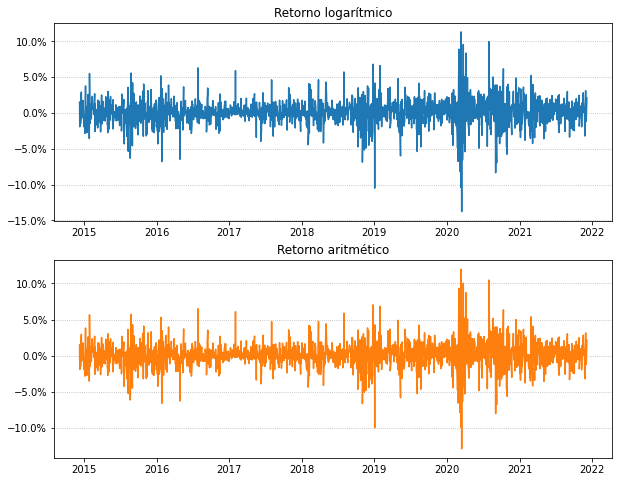

In [6]:
# gráfico de retornos
fig, ax = plt.subplots(2, figsize=(10,8))
ax[0].plot(series_train['log'].mul(100), label='Retorno logarítmico')
ax[0].yaxis.set_major_formatter( mtick.PercentFormatter())
ax[0].grid(axis='y', linestyle=':')
ax[0].set_title('Retorno logarítmico')

ax[1].plot(series_train['pct'].mul(100), color='C1')
ax[1].yaxis.set_major_formatter( mtick.PercentFormatter())
ax[1].grid(axis='y', linestyle=':')
ax[1].set_title('Retorno aritmético')
plt.show()

In [7]:
# cálculo das estatísticas
df_facts = pd.DataFrame(index=['Mínimo','Máximo','Quantil 0.5%','Quantil 1%',
        'Quantil 5%','Quantil 50%','Quantil 95%','Quantil 99%','Quantil 99.5%',
        'Média','Desvio Padrão','Assimetria','Curtose'], columns=['log','pct'])
for col in ['log','pct']:
    df_facts.at['Mínimo', col] = '{:.2f}%'.format(series_train[col].min()*100)
    df_facts.at['Máximo', col] = '{:.2f}%'.format(series_train[col].max()*100)
    df_facts.at['Média', col] = '{:.2f}%'.format(series_train[col].mean()*100)
    df_facts.at['Desvio Padrão', col] = '{:.2f} p.p.'.format(series_train[col].std()*100)
    df_facts.at['Assimetria', col] = series_train[col].skew().round(2)
    df_facts.at['Curtose', col] = series_train[col].kurtosis().round(2) + 3
    for q in [0.01, 0.05, 0.5, 0.95, 0.99]:
        df_facts.at['Quantil {:.0f}%'.format(100*q), col] = '{:.2f}%'.format(series_train[col].quantile(q)*100)
    df_facts.at['Quantil {:.1f}%'.format(100*0.005), col] = '{:.2f}%'.format(series_train[col].quantile(0.005)*100)
    df_facts.at['Quantil {:.1f}%'.format(100*0.995), col] = '{:.2f}%'.format(series_train[col].quantile(0.995)*100)

df_facts

,log,pct
Mínimo,-13.77%,-12.86%
Máximo,11.32%,11.98%
Quantil 0.5%,-6.60%,-6.39%
Quantil 1%,-5.02%,-4.90%
Quantil 5%,-2.71%,-2.67%
Quantil 50%,0.09%,0.09%
Quantil 95%,2.81%,2.85%
Quantil 99%,4.97%,5.09%
Quantil 99.5%,6.19%,6.38%
Média,0.11%,0.12%


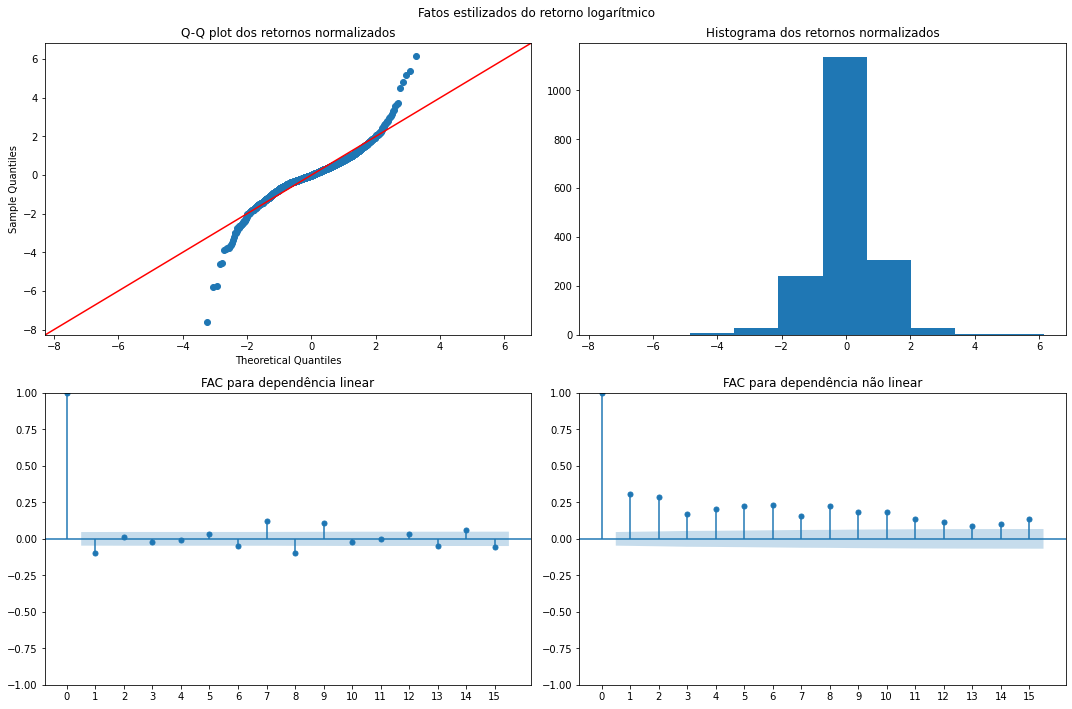

In [8]:
# normalização da série
series_train_norm = series_train.sub(series_train.mean()).div(series_train.std())

# gráfico
col, lags = 'log', 15
fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0][0].set_title(f'Q-Q plot dos retornos normalizados')
sm.qqplot(series_train_norm[col], ax=ax[0][0], line='45')

ax[0][1].set_title(f'Histograma dos retornos normalizados')
ax[0][1].hist(series_train_norm[col])

plot_acf(series_train[col],lags=lags, ax=ax[1][0], title=f'FAC para dependência linear')
ax[1][0].set_xticks(np.arange(lags+1))
ax[1][0].set_xticklabels(np.arange(lags+1))

plot_acf(series_train[col].pow(2),lags=lags, ax=ax[1][1], title=f'FAC para dependência não linear')
ax[1][1].set_xticks(np.arange(lags+1))
ax[1][1].set_xticklabels(np.arange(lags+1))

plt.suptitle('Fatos estilizados do retorno logarítmico')
fig.tight_layout()
plt.show()

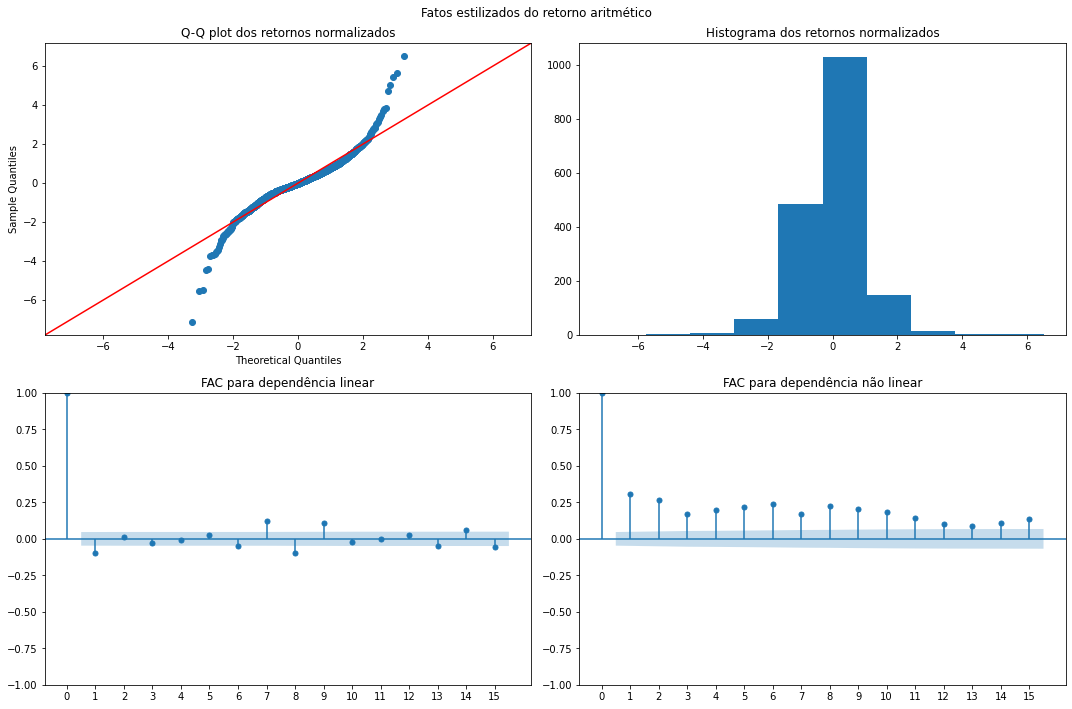

In [9]:
# normalização da série
series_train_norm = series_train.sub(series_train.mean()).div(series_train.std())

# gráfico
col, lags = 'pct', 15
fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0][0].set_title(f'Q-Q plot dos retornos normalizados')
sm.qqplot(series_train_norm[col], ax=ax[0][0], line='45')

ax[0][1].set_title(f'Histograma dos retornos normalizados')
ax[0][1].hist(series_train_norm[col])

plot_acf(series_train[col],lags=lags, ax=ax[1][0], title=f'FAC para dependência linear')
ax[1][0].set_xticks(np.arange(lags+1))
ax[1][0].set_xticklabels(np.arange(lags+1))

plot_acf(series_train[col].pow(2),lags=lags, ax=ax[1][1], title=f'FAC para dependência não linear')
ax[1][1].set_xticks(np.arange(lags+1))
ax[1][1].set_xticklabels(np.arange(lags+1))

plt.suptitle('Fatos estilizados do retorno aritmético')
fig.tight_layout()
plt.show()

In [10]:
# cálculo dos testes
df_tests = pd.DataFrame(index = ['LB linear','LB não linear','teste ARCH','Jarque-Bera'],
                       columns=['log','pct'])
for col in df_tests.columns:
    # ljung-box
    lb = acorr_ljungbox(series_train[col], lags=[20])
    df_tests.at['LB linear',col] = 'Estatística: {:.1f}, p-valor: {:.2f}'.format(lb.loc[20,'lb_stat'], lb.loc[20,'lb_pvalue'])
    lb = acorr_ljungbox(series_train['log'].pow(2), lags=[20])
    df_tests.at['LB não linear',col] = 'Estatística: {:.1f}, p-valor: {:.2f}'.format(lb.loc[20,'lb_stat'], lb.loc[20,'lb_pvalue'])
    # teste ARCH
    arch_result = het_arch(series_train[col])
    df_tests.at['teste ARCH',col] = 'Estatística: {:.1f}, p-valor: {:.2f}'.format(arch_result[0], arch_result[1])
    # jarque-bera
    jb_result = jarque_bera(series_train[col])
    df_tests.at['Jarque-Bera',col] = 'Estatística: {:.1f}, p-valor: {:.2f}'.format(jb_result[0], jb_result[1])

df_tests

,log,pct
LB linear,"Estatística: 115.4, p-valor: 0.00","Estatística: 115.8, p-valor: 0.00"
LB não linear,"Estatística: 1070.2, p-valor: 0.00","Estatística: 1070.2, p-valor: 0.00"
teste ARCH,"Estatística: 322.7, p-valor: 0.00","Estatística: 315.2, p-valor: 0.00"
Jarque-Bera,"Estatística: 3121.4, p-valor: 0.00","Estatística: 2866.5, p-valor: 0.00"


# Tarefa 2: Modelos GARCH

## i) Melhor modelo no período de treinamento

O melhor modelo escolhido com distribuição do erro normal foi o GARCH(2,1), que possui a equação:   
$ r_t = \mu + \sigma_{t|t-1} \epsilon_t $ , $\epsilon_t \sim N(0,1) $   
$ \sigma^2_{t|t-1} = \omega + \alpha_1 (R_{t-1}-\mu)^2 + \alpha_2 (R_{t-1}-\mu)^2 +
 \beta \sigma^2_{t-1|t-2}$
 
Já o melhor modelo escolhido com distribuição do erro igual a Student t foi o GARCH(1,1), que possui a equação:   
$ r_t = \mu + \sigma_{t|t-1} \epsilon_t $ , $\epsilon_t \sim N(0,1) $   
$ \sigma^2_{t|t-1} = \omega + \alpha (R_{t-1}-\mu)^2 + \beta \sigma^2_{t-1|t-2}$

In [11]:
# função para cálculo do melhor modelo
def select_best_garch(data, last_observation, max_p, max_q, distribution):
    best_aic = float('inf')
    for p in range(max_p+1):
        for q in range(max_q+1):
            if p == q == 0: break
            model = arch_model(data, mean='constant', p=p, q=q, dist=distribution)
            model_fit = model.fit(disp=False,last_obs=last_observation)
    
            if model_fit.aic < best_aic: 
                best_model = model_fit
                best_aic = model_fit.aic
    return best_model

In [12]:
# melhor modelo normal
best_normal = select_best_garch(ret['pct']*100, ret.index[idx_train_split-1], 2, 2, 'normal')
best_normal

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    pct   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3343.11
Distribution:                  Normal   AIC:                           6696.22
Method:            Maximum Likelihood   BIC:                           6723.58
                                        No. Observations:                 1760
Date:                Sun, Dec 08 2024   Df Residuals:                     1759
Time:                        18:15:03   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1859  3.725e-02      4.991  6.022e-07 [  0.113,  0.25

In [13]:
# melhor modelo t
best_t = select_best_garch(ret['pct']*100, ret.index[idx_train_split-1], 2, 2, 'studentst')
best_t

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          pct   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -3261.71
Distribution:      Standardized Student's t   AIC:                           6533.42
Method:                  Maximum Likelihood   BIC:                           6560.78
                                              No. Observations:                 1760
Date:                      Sun, Dec 08 2024   Df Residuals:                     1759
Time:                              18:15:12   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

## ii) Diagnóstico dos resíduos padronizados

Ambos os modelos são adequados para capturar a dinâmica da volatilidade. Isso é evidenciado pelos gráficos da FAC do resíduo e do resíduo quadrático, que não possuem valores significativos. O resultado do teste ARCH confirma esse resultado, pois aceita a hipótese nula de homocedasticidade, mostrando que os dois modelos para a volatilidade condicional estão capturando bem a sua dinâmica.

No entanto, o teste de Jarque-Bera rejeita a hipótese nula do resíduo ter distribuição normal para os dois modelos. Esse resultado também é indicado no Q-Q plot para a distribuição normal, que possui grandes diferenças na cauda. Por outro lado, o Q-Q plot da distribuição t Student se ajusta bem aos resíduos, indicando que o modelo GARCH com distribuição t Student pode ser mais adequado para a série de retornos.

In [17]:
# resíduos padronizados
resid = pd.DataFrame(columns=['Normal','Student t'])
resid['Student t'] = best_t.resid/best_t.conditional_volatility
resid['Normal'] = best_normal.resid/best_normal.conditional_volatility

# a biblioteca ARCH redimensiona a volatilidade automaticamente para que os resíduos tenham
# variança = 1, mesmo com distribuição t. 
# É necessário reescalar o resíduo com a variança da distribuição t estimada,
# para compará-lo à distribuição teórica no diagnóstico
resid['Student t'] = resid['Student t']*(best_t.params['nu']/(best_t.params['nu']-2))**0.5
resid.dropna(inplace=True)

In [18]:
# cálculo dos testes
df_tests = pd.DataFrame(index = ['teste ARCH','Jarque-Bera'],
                       columns=['Normal','Student t'])
for col in df_tests.columns:
    # teste ARCH
    arch_result = het_arch(resid[col])
    df_tests.at['teste ARCH',col] = 'Estatística: {:.1f}, p-valor: {:.2f}'.format(arch_result[0], arch_result[1])
    # jarque-bera
    jb_result = jarque_bera(resid[col])
    df_tests.at['Jarque-Bera',col] = 'Estatística: {:.1f}, p-valor: {:.2f}'.format(jb_result[0], jb_result[1])

df_tests

,Normal,Student t
teste ARCH,"Estatística: 4.4, p-valor: 0.93","Estatística: 4.7, p-valor: 0.91"
Jarque-Bera,"Estatística: 552.8, p-valor: 0.00","Estatística: 716.7, p-valor: 0.00"


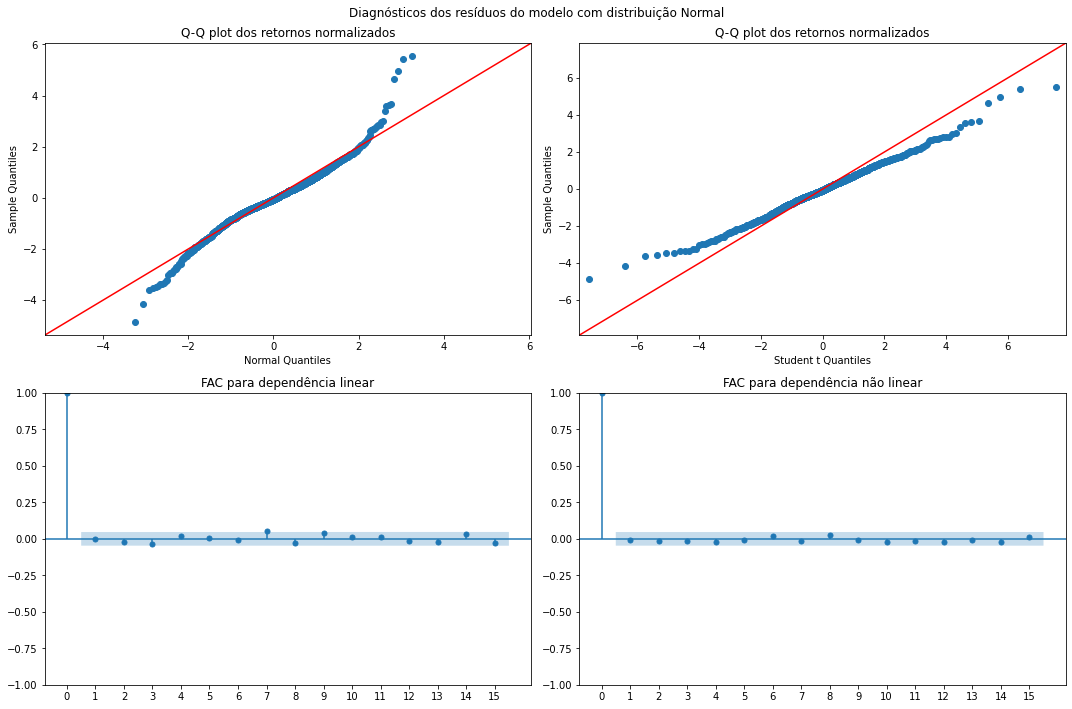

In [19]:
# gráficos para Normal
col, lags = 'Normal', 15
fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0][0].set_title(f'Q-Q plot dos retornos normalizados')
sm.qqplot(resid[col], ax=ax[0][0], line='45')
ax[0][0].set_xlabel('Normal Quantiles')

ax[0][1].set_title(f'Q-Q plot dos retornos normalizados')
sm.qqplot(resid[col], stats.t, distargs=(best_t.params['nu'],), ax=ax[0][1], line='45')
ax[0][1].set_xlabel('Student t Quantiles')

plot_acf(resid[col],lags=lags, ax=ax[1][0], title=f'FAC para dependência linear')
ax[1][0].set_xticks(np.arange(lags+1))
ax[1][0].set_xticklabels(np.arange(lags+1))

plot_acf(resid[col].pow(2),lags=lags, ax=ax[1][1], title=f'FAC para dependência não linear')
ax[1][1].set_xticks(np.arange(lags+1))
ax[1][1].set_xticklabels(np.arange(lags+1))

plt.suptitle('Diagnósticos dos resíduos do modelo com distribuição {}'.format(col))
fig.tight_layout()
plt.show()

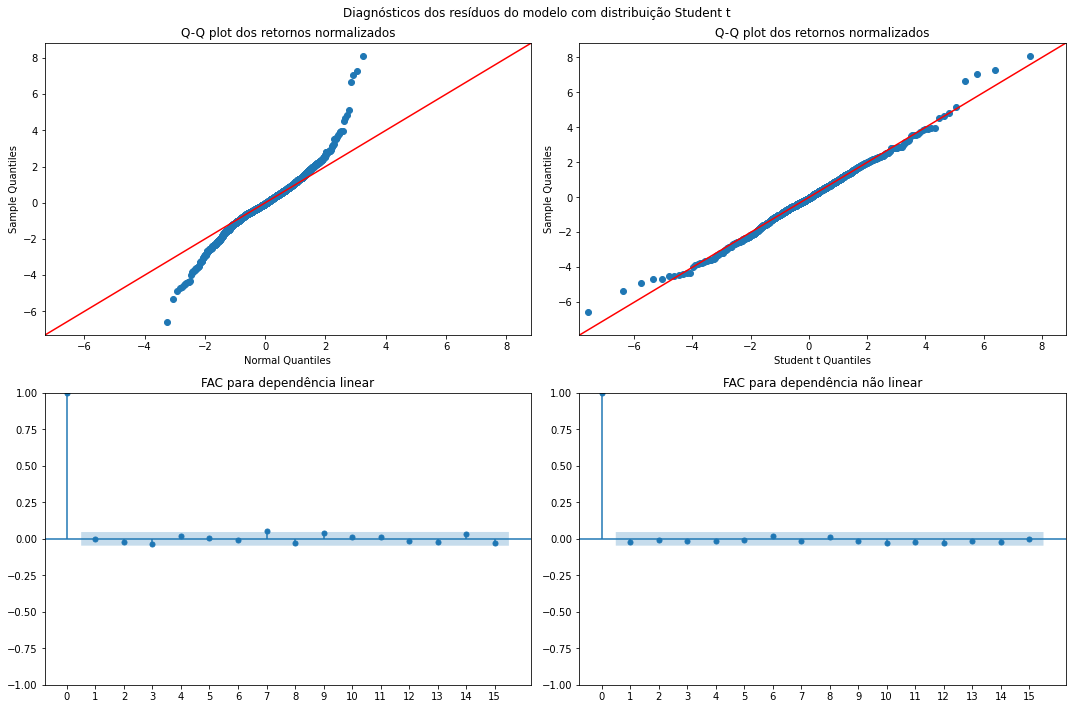

In [20]:
# gráficos para t student
col, lags = 'Student t', 15
fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0][0].set_title(f'Q-Q plot dos retornos normalizados')
sm.qqplot(resid[col], ax=ax[0][0], line='45')
ax[0][0].set_xlabel('Normal Quantiles')

ax[0][1].set_title(f'Q-Q plot dos retornos normalizados')
sm.qqplot(resid[col], stats.t, distargs=(best_t.params['nu'],), ax=ax[0][1], line='45')
ax[0][1].set_xlabel('Student t Quantiles')

plot_acf(resid[col],lags=lags, ax=ax[1][0], title=f'FAC para dependência linear')
ax[1][0].set_xticks(np.arange(lags+1))
ax[1][0].set_xticklabels(np.arange(lags+1))

plot_acf(resid[col].pow(2),lags=lags, ax=ax[1][1], title=f'FAC para dependência não linear')
ax[1][1].set_xticks(np.arange(lags+1))
ax[1][1].set_xticklabels(np.arange(lags+1))

plt.suptitle('Diagnósticos dos resíduos do modelo com distribuição {}'.format(col))
fig.tight_layout()
plt.show()

# Tarefa 3: Back test

Os testes de Kupiec e de Christoffersen rejeitaram a hipótese nula de cobertura adequada do VaR e independência das violações, respectivamente, para os dois modelos. Esses resultados indicam que os modelos não estão totalmente adequados, apesar de capturarem bem a dinâmica da volatilidade. Uma alternativa para melhorar os resultados seria estimar um modelo GARCH mais robusto à assimetria e curtose da série, usando outras distribuições para o erro.

In [28]:
# cálculo do var
idx = pd.MultiIndex.from_product([['Normal','Student t'],['1%','5%']])
var = pd.DataFrame(columns=idx)

# student t
q1, q5 = best_t.model.distribution.ppf([0.01, 0.05], best_t.params['nu'])
forecasts = best_t.forecast(align='target', reindex=False)
var[('Student t','1%')] = forecasts.mean.iloc[:,0].dropna() + forecasts.variance.iloc[:,0].dropna().mul(q1)
var[('Student t','5%')] = forecasts.mean.iloc[:,0].dropna() + forecasts.variance.iloc[:,0].dropna().mul(q5)

# normal
q1, q5 = best_normal.model.distribution.ppf([0.01, 0.05])
forecasts = best_normal.forecast(align='target', reindex=False)
var[('Normal','1%')] = forecasts.mean.iloc[:,0].dropna() + forecasts.variance.iloc[:,0].dropna().mul(q1)
var[('Normal','5%')] = forecasts.mean.iloc[:,0].dropna() + forecasts.variance.iloc[:,0].dropna().mul(q5)
var.head()

Normal            Student t          
                                 1%        5%         1%        5%
Date                                                              
2021-12-06 00:00:00-05:00 -6.779820 -4.739241  -7.997827 -4.588395
2021-12-07 00:00:00-05:00 -6.881111 -4.810859  -8.451105 -4.852014
2021-12-08 00:00:00-05:00 -8.901474 -6.239365 -11.592677 -6.679107
2021-12-09 00:00:00-05:00 -9.835498 -6.899771 -11.644197 -6.709070
2021-12-10 00:00:00-05:00 -8.778710 -6.152565 -10.097350 -5.809446

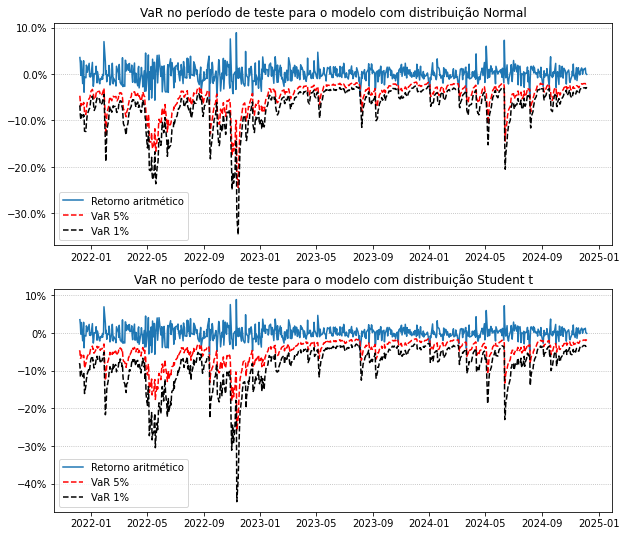

In [22]:
# gráficos do var
col = 'Normal'
fig, ax = plt.subplots(2, figsize=(10,9))
ax[0].plot(ret['pct'].iloc[idx_train_split:].mul(100), label = 'Retorno aritmético')
ax[0].plot(var[(col, '5%')], label = 'VaR 5%', color = 'red', linestyle='--')
ax[0].plot(var[(col, '1%')], label = 'VaR 1%', color = 'black', linestyle='--')
ax[0].yaxis.set_major_formatter( mtick.PercentFormatter())
ax[0].grid(axis='y', linestyle=':')
ax[0].legend()
ax[0].set_title('VaR no período de teste para o modelo com distribuição {}'.format(col))

col = 'Student t'
ax[1].plot(ret['pct'].iloc[idx_train_split:].mul(100), label = 'Retorno aritmético')
ax[1].plot(var[(col, '5%')], label = 'VaR 5%', color = 'red', linestyle='--')
ax[1].plot(var[(col, '1%')], label = 'VaR 1%', color = 'black', linestyle='--')
ax[1].yaxis.set_major_formatter( mtick.PercentFormatter())
ax[1].grid(axis='y', linestyle=':')
ax[1].legend()
ax[1].set_title('VaR no período de teste para o modelo com distribuição {}'.format(col))
plt.show()

In [23]:
# cálculo das violações
violations = pd.DataFrame(columns=var.columns)
for col in violations.columns:
    violations[col] = ret['pct'].mul(100).sub(var[col]).apply(lambda x: 1 if x<0 else 0)

violations.replace({0:np.nan}).dropna(how='all').info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2022-08-26 00:00:00-04:00 to 2024-09-16 00:00:00-04:00
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Normal, 1%)     4 non-null      float64
 1   (Normal, 5%)     13 non-null     float64
 2   (Student t, 1%)  2 non-null      float64
 3   (Student t, 5%)  12 non-null     float64
dtypes: float64(4)
memory usage: 520.0 bytes


In [24]:
# definição dos testes
def func_kupiec_test(var_violations, alpha):
    n_violations = np.sum(var_violations)
    n_obs = len(var_violations)
    
    # Razão de verossimilhança do teste de Kupiec
    p_hat = n_violations / n_obs
    lr_kupiec = -2 * np.log(((1 - alpha)**(n_obs - n_violations) * alpha**n_violations) /
                            ((1 - p_hat)**(n_obs - n_violations) * p_hat**n_violations))
    
    # p-valor
    p_value_kupiec = 1 - stats.chi2.cdf(lr_kupiec, df=1)
    return lr_kupiec, p_value_kupiec

def func_christoffersen_test(var_violations, alpha):
    
    # Contar transições (00, 01, 10, 11)
    n00 = np.sum((var_violations.shift(1).dropna()==0) & (var_violations[1:]==0))
    n01 = np.sum((var_violations.shift(1).dropna()==0) & (var_violations[1:]==1))
    n10 = np.sum((var_violations.shift(1).dropna()==1) & (var_violations[1:]==0))
    n11 = np.sum((var_violations.shift(1).dropna()==1) & (var_violations[1:]==1))
    
    # Probabilidades de transição
    p01 = n01 / (n00 + n01)
    p11 = n11 / (n10 + n11)
    p_hat = (n01 + n11) / (n00 + n01 + n10 + n11)
    
    # Razão de verossimilhança do teste de Christoffersen
    lr_christoffersen = -2 * np.log(
        ((1 - alpha)**(n00 + n10) * alpha**(n01 + n11))/        # verossimilhança de H0
        ((1 - p01)**n00 * p01**n01 * (1 - p11)**n10 * p11**n11) # verossimilhança de Ha
    )
    
    # p-valor
    p_value_christoffersen = 1 - stats.chi2.cdf(lr_christoffersen, df=1)
    return lr_christoffersen, p_value_christoffersen

In [25]:
# cálculo dos testes
df_tests = pd.DataFrame(index = ['Kupiec','Christoffersen'],
                       columns=var.columns)
for col in df_tests.columns:
    alpha = int(col[1][0])/100
    # Kupiec
    result = func_kupiec_test(violations[col], alpha)
    df_tests.at['Kupiec',col] = 'Estatística: {:.1f}, p-valor: {:.2f}'.format(result[0], result[1])
    # Christoffersen
    result = func_christoffersen_test(violations[col], alpha)
    df_tests.at['Christoffersen',col] = 'Estatística: {:.1f}, p-valor: {:.2f}'.format(result[0], result[1])

df_tests

Normal  \
                                              1%   
Kupiec          Estatística: 27.8, p-valor: 0.00   
Christoffersen  Estatística: 27.8, p-valor: 0.00   

                                                   \
                                               5%   
Kupiec          Estatística: 171.8, p-valor: 0.00   
Christoffersen  Estatística: 171.9, p-valor: 0.00   

                                       Student t  \
                                              1%   
Kupiec          Estatística: 36.4, p-valor: 0.00   
Christoffersen  Estatística: 36.4, p-valor: 0.00   

                                                   
                                               5%  
Kupiec          Estatística: 176.5, p-valor: 0.00  
Christoffersen  Estatística: 176.6, p-valor: 0.00

# Tarefa 4: Cálculo do VaR em T+1

De acordo com o \\$VaR calculado para o modelo GARCH com distribuição Student t, existe 5% de chance de ocorrer uma perda maior que \\$34.956, e 1% de chance de ocorrer uma perda maior que \\$19.564 na carteira, no fechamento do mercado no próximo dia útil. A carteira é composta por 5 mil ações da empresa Apple e vale \\$1.214.199, com o último preço de fechamento.

Como esperado, o \\$VaR do modelo com Student t é mais baixo que do modelo com distribuição normal, já que a distribuição t possui a cauda mais grossa. Assim, o modelo com distribuição normal estima que haja 1% de chance de ocorrer uma perda maior que \\$32.386 e 5% de chance de ocorrer uma perda maior que \\$22.237.

Apesar de ambos os modelos não terem passado nos testes do backtest, eu escolheria o VaR 1% do modelo com distribuição t, pois essa distribuição é mais adequada para valores de cauda. De forma semelhante, eu escolheria o modelo com distribuição normal para o VaR 5%.

In [31]:
# cálculo do var
date = datetime.strftime(ret.index[-1] + relativedelta(days=1), '%d %b %y')
idx = pd.MultiIndex.from_product([['Normal','Student t'],['1%','5%']])
var = pd.Series(index=idx, name=f'VaR {date}', dtype=float)

# student t
q1, q5 = best_t.model.distribution.ppf([0.01, 0.05], best_t.params['nu'])
forecasts = best_t.forecast(align='origin', start=ret.index[-1], reindex=False)
var[('Student t','1%')] = forecasts.mean.iloc[-1,0] + forecasts.variance.iloc[-1,0]*q1
var[('Student t','5%')] = forecasts.mean.iloc[-1,0] + forecasts.variance.iloc[-1,0]*q5

# normal
q1, q5 = best_normal.model.distribution.ppf([0.01, 0.05])
forecasts = best_normal.forecast(align='origin', start=ret.index[-1], reindex=False)
var[('Normal','1%')] = forecasts.mean.iloc[-1,0] + forecasts.variance.iloc[-1,0]*q1
var[('Normal','5%')] = forecasts.mean.iloc[-1,0] + forecasts.variance.iloc[-1,0]*q5

In [27]:
# cálculo do $VaR com o valor da carteira e o var estimado
V_t = series['Close'].iloc[-1]*5_000
dollar_var = (V_t)*var/100 #V_t * R_alpha_t+1

print('Valor da carteira em T ({}): ${:,.2f}\n'.format(ret.index[-1].strftime('%d %b'), V_t))
print('$VaR estimado em T+1 ({}):\n'.format(date[:6]))
print(dollar_var.apply(lambda x: '${:,.2f}'.format(x)))

Valor da carteira em T (06 Dec): $1,214,199.98

$VaR estimado em T+1 (07 Dec):

Normal     1%    $-32,386.00
           5%    $-22,237.42
Student t  1%    $-34,956.48
           5%    $-19,564.92
Name: VaR 07 Dec 24, dtype: object
